# Data

The dataset I had picked out contains over 600,000 reddit posts from mental disorder subreddits. The goal for each of the models is to take the text and be able to identify the disorder associated with it. I do wish it included other subreddits so the model would be able to detect ADHD and Autism because those are just as relevant.

Dataset: https://www.kaggle.com/datasets/kamaruladha/mental-disorders-identification-reddit-nlp


# Preparation for Models
## Imports

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from transformers import AutoTokenizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

## Load csv and make it a smaller sample

In [4]:
max_features = 5000

df = pd.read_csv('mental_disorders_reddit.csv')
df = df[df.selftext != '[removed]']
df = df.dropna()
df = df.reset_index(drop=True)
df.sample(max_features)

df = df[['subreddit', 'title']]
df.head()

,subreddit,title
0,BPD,Life is so pointless without others
1,BPD,Cold rage?
2,BPD,I don’t know who I am
3,BPD,HELP! Opinions! Advice!
4,BPD,My ex got diagnosed with BPD


,subreddit,title
0,BPD,Life is so pointless without others
1,BPD,Cold rage?
2,BPD,I don’t know who I am
3,BPD,HELP! Opinions! Advice!
4,BPD,My ex got diagnosed with BPD


## Divide into train and test

In [5]:
# split df into train and test
np.random.seed(1234)
i = np.random.rand(len(df)) < 0.8
train = df[i]
test = df[~i]

print("train data size: ", train.shape)
print("test data size: ", test.shape)

train data size:  (465188, 2)
test data size:  (116029, 2)


## Plot categories

<AxesSubplot: >

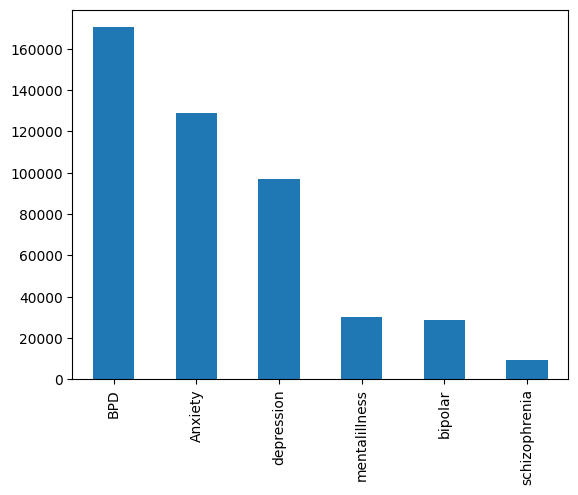

In [6]:
train.subreddit.value_counts().plot(kind='bar')

## Divide into train and test

In [7]:
# set up X and Y
num_labels = 6
batch_size = 100

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

x_train_tok = tokenizer(list(train.title), return_tensors= 'np', padding = True)['input_ids']
x_test_tok = tokenizer(list(test.title), return_tensors= 'np', padding = True)['input_ids']

In [8]:
max_train = x_train_tok.max()
max_test = x_test_tok.max()
dim = max(max_train, max_test)
dim += 1

def vectorize_sequences(sequences, dimension=dim):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Vectorized training data
x_train = vectorize_sequences(x_train_tok[:max_features])
x_test = vectorize_sequences(x_test_tok[:max_features])

In [9]:
# Vectorized labels
encoder = LabelEncoder()
encoder.fit(train.subreddit)
y_train = encoder.transform(train.subreddit)
y_test = encoder.transform(test.subreddit)

y_train = y_train[:max_features]
y_test = y_test[:max_features]

# check shape
print("train shapes:", x_train.shape, y_train.shape)
print("test shapes:", x_test.shape, y_test.shape)
print("test first five labels:", y_test[:5])


train shapes: (5000, 28773) (5000,)
test shapes: (5000, 28773) (5000,)
test first five labels: [1 1 1 1 1]


## Create validation set

In [10]:
x_size = int(len(x_train) * 0.2)
x_val = x_train[:x_size]
partial_x_train = x_train[x_size:]

y_size = int(len(y_train) * 0.2)
y_val = y_train[:y_size]
partial_y_train = y_train[y_size:]

# check shape
print("validation shapes:", partial_x_train.shape, partial_y_train.shape)

validation shapes: (4000, 28773) (4000,)


# Sequential Model

In [10]:
seq_model = models.Sequential()
seq_model.add(layers.Dense(16, activation='relu', input_shape=(dim,)))
seq_model.add(layers.Dense(16, activation='relu'))
seq_model.add(layers.Dense(1, activation='sigmoid'))

seq_model.summary()

# compile
seq_model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# train
history = seq_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                460384    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 460,673
Trainable params: 460,673
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
8/8 [==============================] - 1s 81ms/step - loss: 0.5952 - accuracy: 0.9880 - val_loss: 0.4935 - val_accuracy: 1.0000
Epoch 2/20
8/8 [==============================] - 0s 37ms/step - loss: 0.4300 - accuracy: 1.0000 - val_loss: 0.3662 - val_accuracy: 1.0000
Epoch 3/20
8/8 [====================

In [11]:
pred = seq_model.predict(x_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

# use tf evaluation method

losses_and_metrics = seq_model.evaluate(x_test, y_test, batch_size=128)
print(losses_and_metrics)

157/157 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5000

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

40/40 [==============================] - 0s 4ms/step - loss: 0.0012 - accuracy: 1.0000
[0.001209421781823039, 1.0]


# CNN

In [11]:
cnn_model = models.Sequential()
cnn_model.add(layers.Embedding(max_features, 128, input_length=dim))
cnn_model.add(layers.Conv1D(32, 7, activation='relu'))
cnn_model.add(layers.MaxPooling1D(5))
cnn_model.add(layers.Conv1D(32, 7, activation='relu'))
cnn_model.add(layers.GlobalMaxPooling1D())
cnn_model.add(layers.Dense(1))

cnn_model.summary()

# compile
cnn_model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# train
history = cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(x_val, y_val))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28773, 128)        640000    
                                                                 
 conv1d (Conv1D)             (None, 28767, 32)         28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5753, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5747, 32)          7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 1)                

In [12]:
# use sklearn evaluation
pred = cnn_model.predict(x_test)
pred = [1.0 if p >= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

# use tf evaluation method
losses_and_metrics = cnn_model.evaluate(x_test, y_test, batch_size=128)
print(losses_and_metrics)


157/157 [==============================] - 51s 322ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5000

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

40/40 [==============================] - 50s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
[0.0, 1.0]


# LSTM

In [ ]:
# build a model with LSTM
lstm_model = models.Sequential()
lstm_model.add(layers.Embedding(max_features, 32))
lstm_model.add(layers.LSTM(32))
lstm_model.add(layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

# compile
lstm_model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# train
history = lstm_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          160000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


In [ ]:
# use sklearn evaluation
pred = lstm_model.predict(x_test)
pred = [1.0 if p >= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

# use tf evaluation method
losses_and_metrics = lstm_model.evaluate(x_test, y_test, batch_size=128)
print(losses_and_metrics)

# GRU

In [ ]:
gru_model = models.Sequential()
gru_model.add(layers.Embedding(1000, 32))
gru_model.add(layers.GRU(32))
gru_model.add(layers.Dense(1, activation='sigmoid'))

gru_model.summary()

# compile
gru_model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# train
history = gru_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          32000     
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 38,369
Trainable params: 38,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


In [ ]:
# use sklearn evaluation
pred = gru_model.predict(x_test)
pred = [1.0 if p >= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

# use tf evaluation method
losses_and_metrics = gru_model.evaluate(x_test, y_test, batch_size=128)
print(losses_and_metrics)

# Analysis
Looking at the Sequential model and the CNN model, both achieved perfect accuracy and little to no loss. I believe this is due the large number of columns in the train data. Unfortunately, due the shape of the train data, I am unable to run train LSTM and GRU. Initially, I also had an RNN model, but I deleted it last night because it was taking too long and I wanted to have everything finished by the morning. I did manage to get through one epoch of the RNN, but I had configured my data incorrectly, and it still had a high accuracy. All three were estimating around 5 hours per epoch.